<h1>Additional Insights &amp; Analyses with Markov Chains</h1>

The purpose of this notebook is to demonstrate the capabilities of Markov chains in producing insights to measure effectiveness of each channel in the multi-touch journey of consumers from start to conversion. The notebook should be referred to after training a First-order Markov chain which is described in details in [Multi-Touch Attribution with First-Order Markov Chains](#https://blend360-measurement-library.readthedocs-hosted.com/en/latest/content/Customer%20Journey%20Analytics/Methodologies/Markov%20Chains/MTA_Markov%20chains_FirstOrder.html) notebook.

## 1. Read-in sample data base <a name="se:data"></a>

A sample transition probability matrix is read in. This matrix is the result of a firs-order Markov chain which is trained in [Multi-Touch Attribution with First-Order Markov Chains](#https://blend360-measurement-library.readthedocs-hosted.com/en/latest/content/Customer%20Journey%20Analytics/Methodologies/Markov%20Chains/MTA_Markov%20chains_FirstOrder.html) notebook. In this notebook, every analysis is done using this transition probability matrix. <span style="color:blue;">**NOTE**</span> that this transition matrix is trained based on a sample data and might not be representativ of real-world situations.

In [1]:
import os
import inspect
import pandas as pd
curr_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(curr_dir)
transition_df = pd.read_csv(os.path.join(parent_dir, 
                                         "../Data Transformations/raw data/transition_prob_sample_data.csv"), 
                            index_col = 0)

## 2. Hitting times <a name="se:hit"></a>

Hitting times are among general properties of any Markov chains and describe the probability (or equivalently the expected number of steps) of visiting `state` $j$ starting the journey from `state` $i$. **NOTE** that this is not simply a transition probability as one can visit state $j$ after interim visits to other states. Hitting times can be analytically calculated given a transition probability matrix partitioned according to the following:

$$\begin{equation*}
\text{Transition Probability Matrix} = 
\begin{pmatrix}
T & R \\
0 & I \\
\end{pmatrix}
\end{equation*}$$

Recall that this partition was introduced in [Multi-Touch Attribution with First-Order Markov Chains](#https://blend360-measurement-library.readthedocs-hosted.com/en/latest/content/Customer%20Journey%20Analytics/Methodologies/Markov%20Chains/MTA_Markov%20chains_FirstOrder.html) notebook, **Section 3.1**. $T$ stands for the transient matrix which describes transition probabilities between different channels. $R$ stands for the recurrent matrix which describes the transition probabilities from each channel to the absorbing states of `LOSS` or `CONVERSION`. $0$ denotes the zero matrix which shows transition probability of 0 for transitions from absorbing states to each channel since by definition no transition is possible out of absorbing channel. Equivalently, $I$ denotes the identity matrix describes transition probabilities from absorbing states to absorbing state which by definition is equal to an identity matrix.

In a multi-touch attribution setting, the expected number of steps before absorbing states, i.e., `LOSS` or `CONVERSION`, are of the most interest.  The expected number of steps to absorbing states is given by

$$\begin{equation*}
N = (I - T)^{-1}\, . 1,
\end{equation*}$$ 

where $1$ is vector of ones. For Markov chains with more than one absorbing states, hitting times reveal the average journey length before absorbtion. In multi-touch attribution setting, hitting time can be interpreted as the average life of a customer before `CONVERSION` or `LOSS` if the customer journey starts from a certain channel.

In [2]:
import numpy as np
T = transition_df.drop(['LOSS', 'CONVERSION'], axis = 1).drop(['LOSS', 'CONVERSION'], axis = 0)
R = transition_df[['LOSS', 'CONVERSION']].drop(['LOSS', 'CONVERSION'], axis = 0)
I = np.identity(len(T.columns))

In [3]:
exp_num_steps = np.linalg.inv(I - T).dot(np.ones(len(T)))
step_to_abs_df = pd.DataFrame({'state': T.index,
                               'expected_number_of_steps': exp_num_steps.tolist()})
print(step_to_abs_df.sort_values(by = 'expected_number_of_steps', ascending = False))

                      state  expected_number_of_steps
0                     Start                  2.967822
16     SOCIAL MEDIA|DESKTOP                  2.619288
17      SOCIAL MEDIA|MOBILE                  2.477349
10    NATURAL SEARCH|MOBILE                  2.178242
13       PAID SEARCH|MOBILE                  2.141822
9    NATURAL SEARCH|DESKTOP                  2.105466
6            DISPLAY|MOBILE                  2.103316
15   REFERRAL ENGINE|MOBILE                  2.102001
14  REFERRAL ENGINE|DESKTOP                  2.077272
11                    OTHER                  2.054985
2          AFFILIATE|MOBILE                  2.040941
1         AFFILIATE|DESKTOP                  1.990137
5           DISPLAY|DESKTOP                  1.980725
8              EMAIL|MOBILE                  1.960384
7             EMAIL|DESKTOP                  1.924214
12      PAID SEARCH|DESKTOP                  1.908988
4             DIRECT|MOBILE                  1.855793
3            DIRECT|DESKTOP 

## 3. Absorbing probabilities <a name="se:absorb"></a>

Similar to hitting times in the [previous section](#se:hit), absorbing probabilities are also among general probabilities of Markov chains. These probabilities describe the limiting probability of being absorbed into one of the absorbing states `LOSS` or `CONVERSION` starting from a particular channel. Their analytical calculation, like hitting times, is possible by partitioning a transition probability matrix into its transient ($T$), recurrent ($R$), zero($0$), and idendity ($I$) matrices; see [Section 2](#se:hit) for more details.

$$\begin{equation*}
P = (I - T)^{-1}\, . R
\end{equation*}$$

Absorbing probabilities describe the overall chance to conversion given that a customer started a journey from a particular channel. In multi-touch attribution settings, absorbing probabilities can be another measure of effectiveness for comparing channel performance in converting customers.

In [4]:
abs_prob = np.linalg.inv(I - T).dot(R)
abs_prob_df = pd.DataFrame(abs_prob, columns = ['abs_prob_to_loss', 'abs_prob_to_conversion'])
abs_prob_df.insert(0, 'state', T.index)
abs_prob_df.sort_values(by = 'abs_prob_to_conversion', ascending = False, inplace = True)
abs_prob_df.reset_index(drop = True, inplace = True)
print(abs_prob_df)

                      state  abs_prob_to_loss  abs_prob_to_conversion
0   REFERRAL ENGINE|DESKTOP          0.555146                0.444854
1         AFFILIATE|DESKTOP          0.573720                0.426280
2    REFERRAL ENGINE|MOBILE          0.582271                0.417729
3    NATURAL SEARCH|DESKTOP          0.590265                0.409735
4       PAID SEARCH|DESKTOP          0.593986                0.406014
5          AFFILIATE|MOBILE          0.600373                0.399627
6           DISPLAY|DESKTOP          0.607585                0.392415
7      SOCIAL MEDIA|DESKTOP          0.611518                0.388482
8            DIRECT|DESKTOP          0.619724                0.380276
9                     Start          0.626756                0.373244
10                    OTHER          0.642051                0.357949
11           DISPLAY|MOBILE          0.647079                0.352921
12    NATURAL SEARCH|MOBILE          0.651861                0.348139
13            EMAIL|

### 3.1. Comparing absorbing probabilities with removal effects <a name="sse:absorb-removal"></a>

Considering the **Attribution** section of the [Multi-Touch Attribution with First-Order Markov Chains](#https://blend360-measurement-library.readthedocs-hosted.com/en/latest/content/Customer%20Journey%20Analytics/Methodologies/Markov%20Chains/MTA_Markov%20chains_FirstOrder.html) notebook, attributions as evaluated by removal effects do not match absorbing probabilities of Markov chains. To review the removal effect concept refer to the **Removal effect** section of the same notebook. The idea essentially evaluates attribution as the change in conversion rate if a certain channel is dropped from the Markov chain. Absorbing probabilities on the other hand measure the probability of conversion given the starting channel of the customer.

To that end, the `removal_effects` function below, which is copied from the same notebook, calculates the removal effects for comparison to absorbing probabilities.

In [5]:
def removal_effects(transitions_mat, base_conversion_rate):
    import numpy as np
    from tqdm import tqdm
    RE_dict = {}
    channels = [channel for channel in transitions_mat.columns 
                            if channel not in ['Start', 'LOSS', 'CONVERSION']]
    for channel in tqdm(channels):
        #remove a channel from TPM by dropping it from rows and columns
        removal_df = transitions_mat.drop(channel, axis = 1).drop(channel, axis = 0)
        for column in removal_df.columns:
            #calculate the drop in conversion rate
            row_sum = np.sum(list(removal_df.loc[column]))
            null_pct = float(1) - row_sum
            if null_pct != 0:
                removal_df.loc[column]['LOSS'] = null_pct
            removal_df.loc['LOSS']['LOSS'] = 1.0
        #partition T and R matrix from the reduced transition matrix
        R = removal_df[['LOSS', 'CONVERSION']].drop(['LOSS', 'CONVERSION'], axis = 0)
        T = removal_df.drop(['LOSS', 'CONVERSION'], axis = 1).drop(['LOSS', 'CONVERSION'], axis = 0)
        I = np.identity(len(T.columns))
        #calculate absorbtion probabilities for the reduced matrix, 0: loss probabilities, 1: conversion probabilities
        P = np.dot(np.linalg.inv(I - T), np.asarray(R))
        #extract the new conversion rate from the `Start` state
        new_cr = pd.DataFrame(P, index = R.index)[[1]].loc['Start'].values[0]
        RE = 1 - new_cr / base_conversion_rate
        RE_dict[channel] = RE
    #sum of removal effects
    re_sum = np.sum(list(RE_dict.values()))
    #normalize the removal effect
    new_RE_dict = {k: v / re_sum for k, v in RE_dict.items()}
    return RE_dict, new_RE_dict

## calculate removal effects
total_conversions = 224609 ## this is taken from the Multi-Touch Attribution with First-Order Markov Chains notebook
base_conversion_rate = abs_prob_df.loc[abs_prob_df.state == 'Start', 'abs_prob_to_conversion'].values[0]
removal_effects_dict, normalized_removal_effects_dict = removal_effects(transition_df, base_conversion_rate)

## calculate attributions
new_attributions = {k:v  * total_conversions for k, v in normalized_removal_effects_dict.items()}
new_attributions = pd.DataFrame.from_dict(new_attributions, orient = 'index', columns = ['attribution'])
new_attributions.reset_index(inplace = True)
new_attributions.rename(columns = {'index': 'channel'}, inplace = True)
new_attributions.sort_values(by = 'attribution', ascending = False, inplace = True)
new_attributions.reset_index(drop = True, inplace = True)
new_attributions['per'] = new_attributions.attribution / new_attributions.attribution.sum()

100%|█████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 118.27it/s]


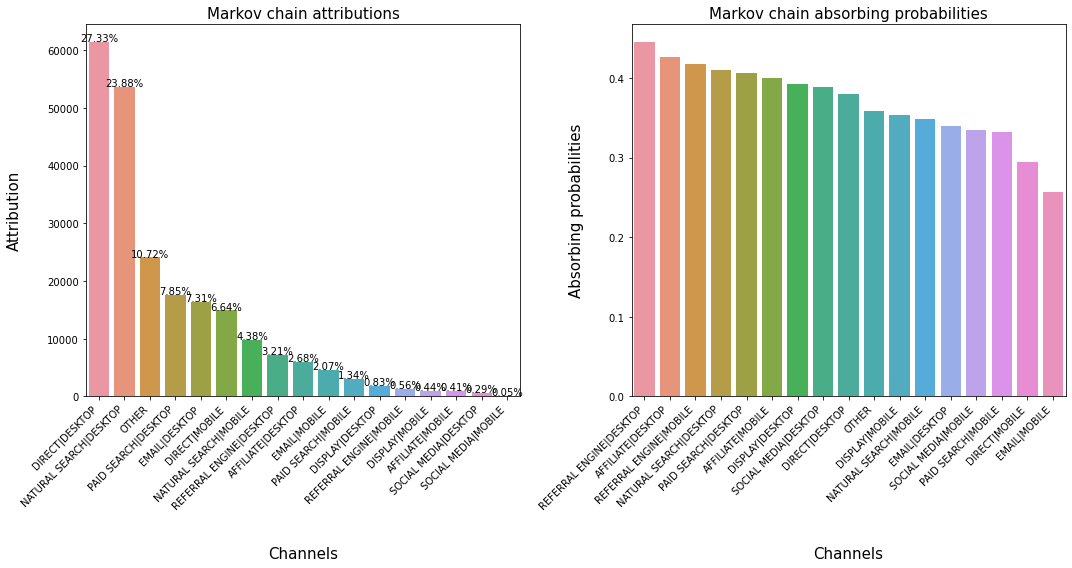

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fig, (ax1, ax2) = plt.subplots(nrows = 1, 
                               ncols = 2, 
                               figsize = (15, 8))
g1 = sns.barplot(x = 'channel', 
                 y = 'attribution',
                 data = new_attributions,
                 ax = ax1)

for index, row in new_attributions.iterrows():
    g1.text(row.name, 
            row.attribution + 100, 
            str(round(row.per * 100, 2)) + "%", 
            color = 'black', 
            ha = "center")

g1.set_xticklabels(ax1.get_xticklabels(), rotation = 45, ha = 'right')
g1.set_title('Markov chain attributions', fontsize = 15)
g1.set_xlabel("Channels", labelpad = 35, fontsize = 15)
g1.set_ylabel("Attribution", labelpad = 25, fontsize = 15)

g2 = sns.barplot(x = 'state', 
                 y = 'abs_prob_to_conversion',
                 data = abs_prob_df.loc[abs_prob_df.state != 'Start',],
                 ax = ax2)
    
g2.set_xticklabels(ax2.get_xticklabels(), rotation = 45, ha = 'right')
g2.set_title('Markov chain absorbing probabilities', fontsize = 15)
g2.set_xlabel("Channels", labelpad = 35, fontsize = 15)
g2.set_ylabel("Absorbing probabilities", labelpad = 25, fontsize = 15)

plt.tight_layout()
plt.show()

As can be seen, the results of the two analyses do not agree. It does not necessarily mean that one of the two results is correct, rather, while providing a measure of effectiveness, attributions and absorbing probabilities show two separate measures. Attribution is a measure of importance over all customer journeys regardless of the start channel. Absorbing probabilities depend on the starting channel, therefore, they identify the most effective channel in converting a customer when customer start their journeys from that channel. 

## 4. Aggregating Markov states <a name="se:aggregate"></a>

For a Markov chain with a lot of state, sometimes it is useful to aggregate some of the states into one state. In multi-touch attribution settings, some channels can be aggregated across other factors, e.g., device types. For example, in the case of this implementation, `MOBILE` and `DESKTOP` channels can be aggregated into each other. The transition probability matrix should transform in such a way that transitions to and out of the aggregated channel behave equivalenlty to transitions to and out of each channel. In other words, the probability of being in the aggregated channel is the sum of the probabilities of being in each channel.

The following formula to transform the transition probability matrix is based on Wales's method of aggregation reviewed in [Aggregation of Markov flows I: Theory](#https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5869541/). To simplify, first, consider a simple case of aggregating a single state into another. For a Markov chain with a set of states $S$, assume that state $j$ is aggregated into state $i$ where the new aggregated state is also referred to as $i$. Then, new transition probabilities are:

$$
\begin{equation*}
    \begin{array}{ll}
        & P'_{ki} = P_{ki} + P_{kj} & \qquad \forall k\in S, k\neq i, j\\
        & P'_{ik} = P_{ik} + P_{ij} (1 - P_{jj})^{-1}  P_{jk} & \qquad \forall k\in S, k\neq i, j
    \end{array}
\end{equation*}
$$

The same logic applies to a case where multiple states (e.g., in set $X$) are aggregated into a single state $i$.

$$
\begin{equation*}
    \begin{array}{ll}
        & P'_{ki} = P_{ki} + \sum_{j\in X}P_{kj} & \qquad \forall k\in S, k\neq i, j\\
        & P'_{ik} = P_{ik} + P_{iX} (1 - P_{XX})^{-1}  P_{Xk} & \qquad \forall k\in S, k\neq i, k\notin X
    \end{array}
\end{equation*}
$$

where $P_{iX}$ and $P_{Xi}$ are verctors of transition probabilities from state $i$ to all the states in $X$ and from all the states in $X$ to state $i$, respectively. $P_{XX}$ denotes a submatrix of transition probabilities between all the states in set $X$. Note that $(1 - P_{XX})$ should be invertible which only will happen if there is a positive probability to eventually leave $X$ from each of its nodes. In other words, this wil only happen if for all states in $X$ there is a positive transition probability to any state outside $X$.

The function below, `markov aggregate` implements a single aggregation schema where channel `chnl_to_rem` is removed from the transition probability matrix and is aggregated into `chnl_to_agg`. Notice that transition probabilities for rows of `LOSS` and `CONVERSION` (i.e., zero matrix as denoted in [Section 2](#se:hit)) do not change.

In [7]:
def markov_aggregate(tpm_df, chnl_to_rem, chnl_to_agg):
    agg_tpm_df = tpm_df.drop(columns = chnl_to_rem, index = chnl_to_rem)
    for idx, row in agg_tpm_df.iterrows():
        if row.name in ['LOSS', 'CONVERSION']:
            pass
        elif row.name == chnl_to_agg:
            for col_name, col in agg_tpm_df.iteritems():
                agg_tpm_df.loc[agg_tpm_df.index == row.name, col_name] = \
                    tpm_df.loc[tpm_df.index == row.name, col_name].values[0] + \
                        tpm_df.loc[tpm_df.index == row.name, chnl_to_rem].values[0] * \
                        (1 / (1 - tpm_df.loc[tpm_df.index == chnl_to_rem, chnl_to_rem].values[0])) * \
                        tpm_df.loc[tpm_df.index == chnl_to_rem, col_name].values[0]
        else:
            agg_tpm_df.loc[agg_tpm_df.index == row.name, chnl_to_agg] = \
                tpm_df.loc[tpm_df.index == row.name, chnl_to_agg].values[0] + \
                tpm_df.loc[tpm_df.index == row.name, chnl_to_rem].values[0]
    return agg_tpm_df

For this implementation, all channels associated with `MOBILE` device type are aggregated into their respective channel associated with `DESKTOP`. Then, device name is dropped from all channel names.

In [8]:
agg_transition_df = transition_df.copy(deep = True)
temp_transition_df = transition_df.copy(deep = True)
for index, row in transition_df.iterrows():
    if 'MOBILE' in row.name:
        chnl_to_rem = row.name
        chnl_to_agg = chnl_to_rem.replace('MOBILE', 'DESKTOP')
        agg_transition_df = markov_aggregate(temp_transition_df, chnl_to_rem, chnl_to_agg)
    temp_transition_df = agg_transition_df.copy(deep = True)

agg_transition_df.columns = agg_transition_df.columns.str.replace('\|DESKTOP', '')
agg_transition_df.index = agg_transition_df.index.str.replace('\|DESKTOP', '')

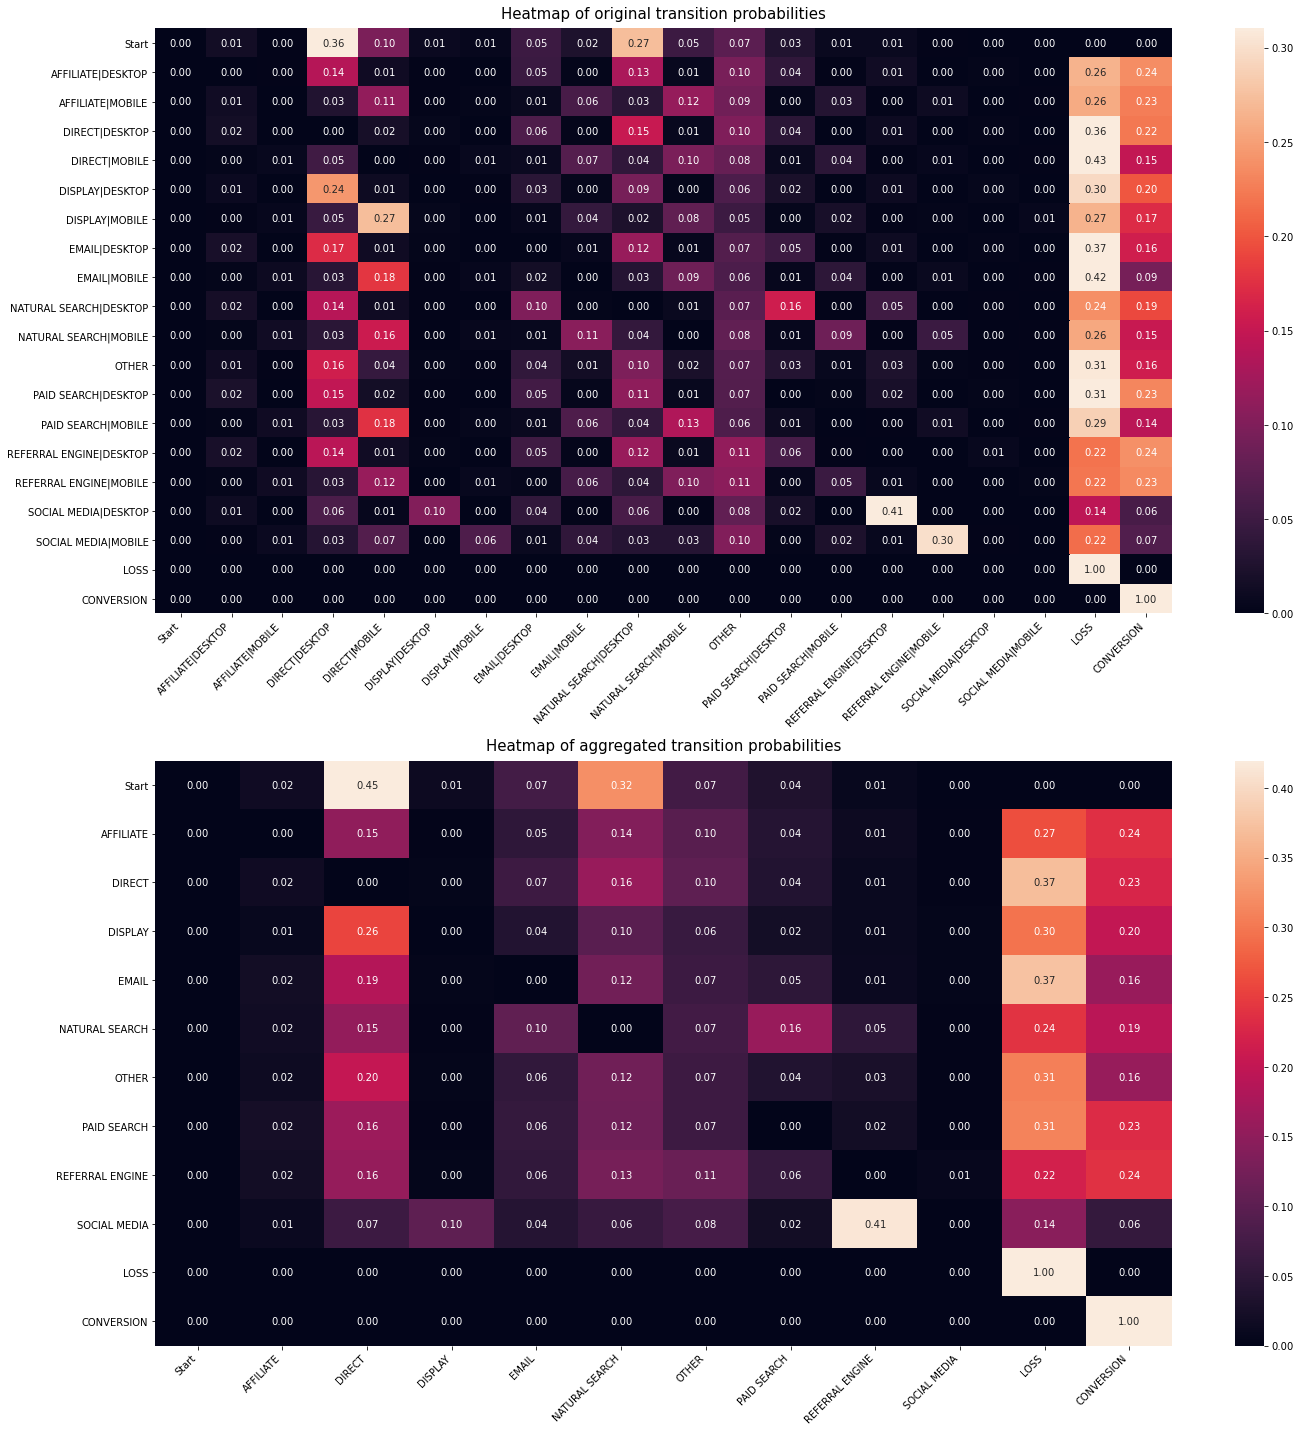

In [9]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
%matplotlib inline

fig, (ax1, ax2) = plt.subplots(nrows = 2, 
                               ncols = 1, 
                               figsize = (20, 20))
g1 = sns.heatmap(transition_df, 
                 annot = True, 
                 robust = True, 
                 fmt = ".2f",
                 ax = ax1)
g2 = sns.heatmap(agg_transition_df, 
                 annot = True, 
                 robust = True, 
                 fmt = ".2f",
                 ax = ax2)

g1.set_xticklabels(ax1.get_xticklabels(), rotation = 45, ha = 'right')
g1.set_title('Heatmap of original transition probabilities', fontsize = 15, pad = 10)
g1.set_xlabel("")
g1.set_ylabel("")

g2.set_xticklabels(ax2.get_xticklabels(), rotation = 45, ha = 'right')
g2.set_title('Heatmap of aggregated transition probabilities', fontsize = 15, pad = 10)
g2.set_xlabel("")
g2.set_ylabel("")

plt.tight_layout()
plt.show()

## 5. Most probable paths <a name="se:paths"></a>

In a Markov chain, probability of a particular series of transitions from one state to another is equal to the product of all transition probabilities in between. In multi-touch attribution settings, probability of the following path 

DIRECT --> EMAIL --> PAID SEARCH --> CONVERSION

is equal to 

$$P(\text{Start}, \text{DIRECT}) \times P(\text{DIRECT}, \text{EMAIL}) \times P(\text{EMAIL}, \text{PAID SEARCH}) \times P(\text{PAID SEARCH}, \text{CONVERSION})$$

Therefore, finding the most probable path in a Markov chain requires maximization of product of probabilities over all potential paths. Since maximizing a product is equal to maximizing its logarithmic sum, finding the most probable path is equivalent to finding the shortest path in a graph where the weight of each edge is the negative logarithm of its transition probability. To find a shortest path in a directed graph, Dijkstra's algorithm is typically used. The `networkx` library has different versions of it implemented. The function `k_shortest_paths` below is using Yen's algorithm to identify the first $k$ shortest paths. For more details, refer to networkX documentation, [here](#https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.simple_paths.shortest_simple_paths.html#networkx.algorithms.simple_paths.shortest_simple_paths). Note that in this implementation, the aggregated transition probability matrix is used. One can simply replace that with the original transition probability matrix too.

In [10]:
def k_shortest_paths(G, source, target, k, weight = None):
    from itertools import islice
    import networkx as nx
    return list(islice(nx.shortest_simple_paths(G, source, target, weight = weight), k))

In [11]:
import networkx as nx
neg_log_tpm = -np.log(agg_transition_df)
G = nx.from_pandas_adjacency(neg_log_tpm, create_using = nx.DiGraph)
## get the top 5 most probable paths from Start to CONVERSION
k_shortest_paths(G, 'Start', 'CONVERSION', 5, 'weight')

<ipython-input-11-87e48a2f9433>:2: RuntimeWarning: divide by zero encountered in log
  neg_log_tpm = -np.log(agg_transition_df)


[['Start', 'DIRECT', 'CONVERSION'],
 ['Start', 'NATURAL SEARCH', 'CONVERSION'],
 ['Start', 'DIRECT', 'NATURAL SEARCH', 'CONVERSION'],
 ['Start', 'NATURAL SEARCH', 'PAID SEARCH', 'CONVERSION'],
 ['Start', 'EMAIL', 'CONVERSION']]

## 6. First-order Sankey diagram <a name="se:sankey"></a>

Below, a visualization of transition probability matrix in a circular sankey diagram is presented. In this visualization, higher transition probabilities are depicted with wider flow betweeen pairs of channel. Each channel has a node which shares its color with transition probabilities out of that channel. Hovering the curser over a channel node will isolate its transitions.

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
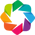

In [12]:
import holoviews as hv
node_names = agg_transition_df.index
node_names = node_names.tolist()
chord_df = agg_transition_df.melt(var_name = 'to_channel',
                                  value_name = 'prob',
                                  ignore_index = False)\
                            .reset_index()
chord_df = chord_df[chord_df.prob != 0]
chord_df = chord_df.loc[~chord_df.from_channel.isin(['LOSS', 'CONVERSION']), ]
hv.extension("bokeh")
chord_dt = hv.Dataset(pd.DataFrame(node_names, columns = ["names"]))

In [13]:
%%opts Chord [height=800 width=800 title="Transition probabilities between channels" labels="names"]
%%opts Chord(node_color="names" node_cmap="Category20" edge_color="from_channel" edge_cmap='Category20')
chord = hv.Chord((chord_df[['from_channel', 'to_channel', 'prob']], chord_dt))

In [14]:
chord

:Chord   [from_channel,to_channel]   (prob)